In [2]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [3]:
import numpy as np
import librosa, librosa.display
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import keras
from sklearn.model_selection import train_test_split
import tensorflow
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
!pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.28-cp37-none-any.whl size=8528 sha256=b47fd7f444113bbeab3326cd473b84d16bb0bf2bb8569e2c844ba7b3503845ca
  Stored in directory: /root/.cache/pip/wheels/c3/2e/92/87e6d66cf837c54f151466bd1da6fe081e727f78f5ab05518f
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-cp37-none-any.whl size=7610 sha256=a8594beb38e1703f181d98c96705cff7c1a7359583b4deac0a8ef7d4003a5442
  Stored in directory: /root/.cache/pip/wheels/2a/62/31/d348320becc60729f508a2c5aad445b94d7543c5cb577cfb9d
  Created wheel for compress-json: filename=compress_json-1.0.4-cp37-none-any.whl size=4586 sha256=b7d37fc612828f065b95e09b93a89c9a7cbeeed823187931b583512f1a94d303
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [4]:
path = 'content/MyDrive/genres_original/'
genre = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

data = []
labels = []
for i in range(len(genre)):
  path_full = path+genre[i]+'/*.wav'
  for name in glob.glob(path_full):
    data.append([genre[i], name])
    labels.append(genre[i])

import random
random.shuffle(data)
for i in range(len(data)):
  labels.append(data[i][0])

In [5]:
def split_data(timeseriesdata, sections):
  
  N = len(timeseriesdata)
  sections = sections//1
  len_of_section = N//sections
  
  list_of_series = []
  for i in range(0,sections,1):
    time_subsection = timeseriesdata[i*len_of_section:(i+1)*len_of_section]
    list_of_series.append(time_subsection)
  
  list_of_series = np.array(list_of_series)
  return list_of_series

In [6]:
speclabellist = []
N = len(data)

for i in tqdm(range(N)):
  filepath = data[i][1]
  label = data[i][0]
  y, sr = librosa.load(filepath, sr = 22050)
  list_of_y = split_data(y, 10)
  for i in range(len(list_of_y)):
    signal = list_of_y[i][:66000-1]
    speclabellist.append([signal, label])

100%|██████████| 999/999 [06:16<00:00,  2.65it/s]


In [7]:

audio_data = []
extended_labels = []
random.shuffle(speclabellist)

for i in range(len(speclabellist)):
  audio_data.append(speclabellist[i][0])
  extended_labels.append(speclabellist[i][1])

audio_data =np.array(audio_data) 
print(audio_data.shape)
assert len(extended_labels) == len(audio_data)

(9990, 65999)


In [8]:
from numpy import load
from csv import reader
import collections

audio_data_np = audio_data
mylabels = extended_labels

In [9]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

audio_data_np = np.array(audio_data_np)

print('Data Instance: ', audio_data_np[0])
print('Data Shape: ', audio_data_np.shape)

scaler = StandardScaler()
audio_data_np = scaler.fit_transform(audio_data_np)

X_train, X_test, y_train, y_test = train_test_split(audio_data_np, mylabels, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

print('X Training Data Length: ', len(X_train), X_train[0])
print('X Testing Data Length: ', len(X_test), X_test[0])
print('Y Training Data Length: ', len(y_train), y_train[0])
print('Y Testing Data Length: ', len(y_test), y_test[0])

encoder = preprocessing.LabelEncoder()
encoder.fit(mylabels)

labels_n = encoder.transform(y_train)
labels_matrix =keras.utils.to_categorical(labels_n, dtype='float32')

labels_n_test = encoder.transform(y_test)
labels_matrix_test =keras.utils.to_categorical(labels_n_test, dtype='float32')

labels_n_val = encoder.transform(y_val)
labels_matrix_val =keras.utils.to_categorical(labels_n_val, dtype='float32')


Data Instance:  [0.19439697 0.16574097 0.10437012 ... 0.08618164 0.11901855 0.09313965]
Data Shape:  (9990, 65999)
X Training Data Length:  7992 [-0.36993897 -0.29103896 -0.18490404 ... -0.15334108 -0.12655006
  0.07234187]
X Testing Data Length:  999 [ 1.2853376   0.17886128 -1.0896709  ... -0.56653273 -0.467946
 -0.3668005 ]
Y Training Data Length:  7992 metal
Y Testing Data Length:  999 metal


In [10]:
class_instances=collections.Counter(labels_n)
print(class_instances)

Counter({8: 826, 9: 815, 0: 805, 5: 803, 7: 802, 4: 801, 6: 800, 2: 783, 3: 779, 1: 778})


In [11]:
features_convolution = np.reshape(X_train,(len(y_train),2129, -1))
print(features_convolution.shape[1:])
features_convolution_test = np.reshape(X_test,(len(y_test),2129, -1))
print(features_convolution_test.shape[1:])
features_convolution_val = np.reshape(X_val,(len(y_val),2129, -1))
print(features_convolution_val.shape[1:])

(2129, 31)
(2129, 31)
(2129, 31)


In [12]:
from keras.layers import Layer
import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [13]:
import tensorflow as tf

from keras.layers import Dense, Dropout, Activation, Flatten, Input, SpatialDropout2D
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Activation, Bidirectional, LSTM, GRU, TimeDistributed, AveragePooling1D, ReLU
from keras.models import Model
from keras import optimizers

inputs = Input(shape = features_convolution.shape[1:])
LSTM_units = 128

x = Conv1D(filters = 16, kernel_size = 6)(inputs)
x = ReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size = 8, strides = 1)(x)
x = Conv1D(filters = 32, kernel_size = 4)(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size = 6, strides = 1)(x)
x = Conv1D(filters = 64, kernel_size = 4)(x)
x = ReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size = 6, strides = 1)(x)
x = AveragePooling1D(pool_size = 4)(x)
x = Bidirectional(GRU(LSTM_units, return_sequences = True))(x)
x = attention()(x)
x = Dense(64)(x)
outputs= Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.8, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2129, 31)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2124, 16)          2992      
_________________________________________________________________
re_lu (ReLU)                 (None, 2124, 16)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2124, 16)          64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2117, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2114, 32)          2080      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 2114, 32)          0     

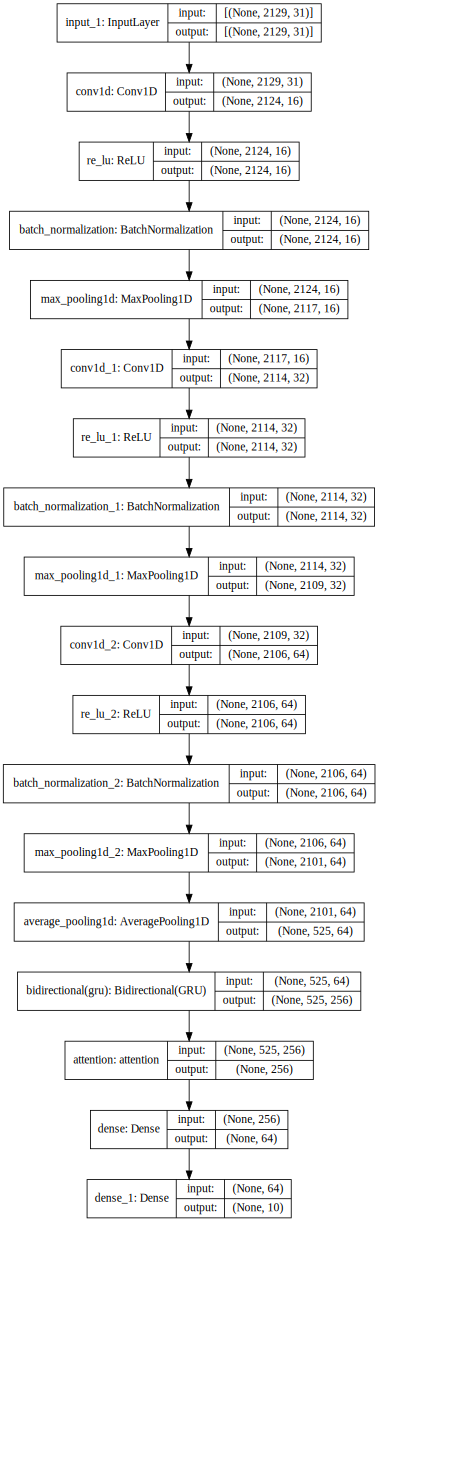

In [15]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

In [16]:
print(len(features_convolution), len(labels_matrix))
print(len(features_convolution_val), len(labels_matrix_val))
print(len(features_convolution_test), len(labels_matrix_test))

7992 7992
999 999
999 999


In [17]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import  ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-4, mode='min')

epochs = 30
history = model.fit(features_convolution, labels_matrix,batch_size=128,  epochs=epochs, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=(features_convolution_val, labels_matrix_val))

Epoch 1/30
63/63 [==============================] - 326s 5s/step - loss: 1.8105 - accuracy: 0.3575 - val_loss: 1.9266 - val_accuracy: 0.3463
Epoch 2/30
63/63 [==============================] - 308s 5s/step - loss: 1.3587 - accuracy: 0.5292 - val_loss: 1.7601 - val_accuracy: 0.3804
Epoch 3/30
63/63 [==============================] - 309s 5s/step - loss: 1.1555 - accuracy: 0.6077 - val_loss: 1.3424 - val_accuracy: 0.5345
Epoch 4/30
63/63 [==============================] - 305s 5s/step - loss: 1.0263 - accuracy: 0.6499 - val_loss: 1.3845 - val_accuracy: 0.4965
Epoch 5/30
63/63 [==============================] - 306s 5s/step - loss: 0.9154 - accuracy: 0.6913 - val_loss: 1.2421 - val_accuracy: 0.5766
Epoch 6/30
63/63 [==============================] - 306s 5s/step - loss: 0.8149 - accuracy: 0.7184 - val_loss: 0.9043 - val_accuracy: 0.6907
Epoch 7/30
63/63 [==============================] - 317s 5s/step - loss: 0.7280 - accuracy: 0.7646 - val_loss: 0.8388 - val_accuracy: 0.7377
Epoch 8/30
63

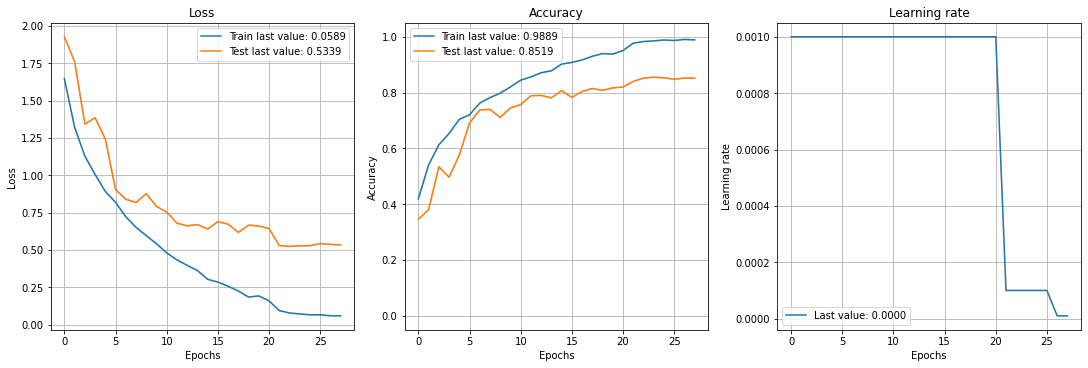

In [18]:

from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

In [19]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

32/32 [==============================] - 9s 271ms/step - loss: 0.4810 - accuracy: 0.8639


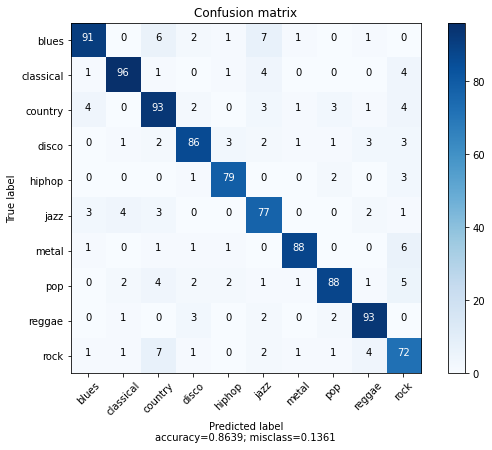

In [20]:

from sklearn.metrics import confusion_matrix

model.evaluate(features_convolution_test, labels_matrix_test)

y_pred = model.predict(features_convolution_test).argmax(axis = 1)
y_true = labels_matrix_test.argmax(axis = 1)
cm = confusion_matrix(y_true,y_pred)
plot_confusion_matrix(cm, genre)

In [21]:
model.save('END2END-GenreModel')

INFO:tensorflow:Assets written to: END2END-GenreModel/assets


INFO:tensorflow:Assets written to: END2END-GenreModel/assets
